# Assginment1

2021021699 Yuwon Lee<br>
2021021581 Jinha Lim<br>
2021021580 Shinhye Lee

## Writing a renderer

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import atan, sin, cos
import numpy as np

In [2]:
# Defining the functions from the pdf file
# Nothing changed from pdf
def show_3d(vertices, edges):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]],
                [p1[2], p2[2]])
    ax.set_ylim(-5, 5)
    ax.set_xlim(-5, 5)
    ax.set_zlim(-5, 5)
    plt.show()

def show_2d(vertices, edges, size):
    fig = plt.figure()
    ax = fig.gca()
    for edge in edges:
        p1 = vertices[edge[0]]
        p2 = vertices[edge[1]]
        ax.plot([p1[0], p2[0]],
                [p1[1], p2[1]])
    ax.set_ylim(0, size[0])
    ax.set_xlim(0, size[1])
    plt.show()

- Converting to homogeneous coordinates

$(x,y) \rightarrow  \begin{bmatrix} x \\ y \\ 1 \end{bmatrix}$ &emsp;&emsp;&emsp; $(x,y,z) \rightarrow \begin{bmatrix} x \\ y \\ z \\ 1  \end{bmatrix}$

- Converting from homogeneous coordinates to standard 2D/3D

$\begin{bmatrix} x \\ y \\ w \end{bmatrix} \rightarrow (x/w, y/w)$ &emsp;&emsp;&emsp; $\begin{bmatrix} x \\ y \\ z \\ w  \end{bmatrix} \rightarrow (x/w, y/w, z/w)$

In [3]:
# Defining the conversion function for homogeneous to orthogonal coordinates and the reverse one
def to_homogeneous(coords):
    # Converting to homogeneous function is adding an additional column that value is 1 for the point
    h_coord = []
    
    # Adding another column via for loop
    for c in coords:
        c = np.append(c,np.array([1]))
        h_coord.append(c)

    return np.array(h_coord)

def from_homogeneous(coords):
    # Converting from the homogenous coordinate system need to be separated of case that is 2D and 3D
    w_coord = []
    for c in coords:
        # If the coordinate length is 4 then it needed to be converted to 3D coordinate. From the solutiuon in the pdf file, divide all three 
        # value with the last value
        if c.shape[0] == 4:
            c = c/c[3]
            c = c[:3]

            w_coord.append(c)

        # Just same as 3d point but, executing with only 2 values
        else:
            c = c/c[2]
            c = c[:2]

            w_coord.append(c)

    return np.array(w_coord)

- Rotation matrix

$R = \begin{bmatrix} \cos\theta + {u_x}^2(1-\cos\theta) & u_xu_y(1-\cos\theta) - u_z\sin\theta & u_xu_z(1-\cos\theta) + u_y\sin\theta \\ u_yu_x(1-\cos\theta) + u_z\sin\theta & \cos\theta + {u_y}^2(1-\cos\theta) & uyxu_z(1-\cos\theta) - u_x\sin\theta \\ u_zu_x(1-\cos\theta) - u_y\sin\theta & u_zu_y(1-\cos\theta) + u_x\sin\theta & \cos\theta + {u_z}^2(1-\cos\theta)\end{bmatrix}$<br><br>
&emsp;&emsp;\*$u$ is a axis vector of $\sqrt{{u_x}^2 + {u_y}^2 + {u_z}^2}=1$

In [4]:
def create_rotation(u, theta):
    # Creating the rotation matrix from the pdf file
    rotation_matrix = np.eye(4) # Creating a matrix concept of placeholder

    rotation_matrix[0][0] = cos(theta) + u[0]**2*(1-cos(theta))
    rotation_matrix[0][1] = u[0]*u[1]*(1-cos(theta)) - u[2]*sin(theta)
    rotation_matrix[0][2] = u[0]*u[2]*(1-cos(theta)) + u[1]*sin(theta)
    rotation_matrix[1][0] = u[1]*u[0]*(1-cos(theta)) + u[2]*sin(theta)
    rotation_matrix[1][1] = cos(theta) + u[1]**2*(1-cos(theta))
    rotation_matrix[1][2] = u[1]*u[2]*(1-cos(theta)) - u[0]*sin(theta)
    rotation_matrix[2][0] = u[2]*u[0]*(1-cos(theta)) - u[1]*sin(theta)
    rotation_matrix[2][1] = u[2]*u[1]*(1-cos(theta)) + u[0]*sin(theta)
    rotation_matrix[2][2] = cos(theta) + u[2]**2*(1-cos(theta))

    return rotation_matrix

#### Translation matrix via homogeneous coordinate
- 2D

$T = \begin{bmatrix}1 & 0 & t_1 \\0 & 1 & t_2 \\0 & 0 & 1\end{bmatrix}$
- 3D

$T = \begin{bmatrix}1 & 0 & 0 & t_1 \\0 & 1 & 0 & t_2 \\0 & 0 & 1 & t_3 \\0 & 0 & 0 & 1\end{bmatrix}$ 

In [5]:
def create_translation(translate):
    # Creating the translation matrix
    translation_matrix = np.eye(4)  # Creating a matrix concept of placeholder
    translation_matrix[0][3] = translate[0]
    translation_matrix[1][3] = translate[1]
    translation_matrix[2][3] = translate[2]

    return translation_matrix

#### Getting Extrinsics matrix<br>
- step1: Translate by -c 
- step2: Rotate by R
     * First rotate by x-axis then y and then z

In [6]:
def get_extrinsic_matrix(position, orientation):
    # Creating a extrinsic matrix    
    angle_x = orientation[0]
    angle_y = orientation[1]
    angle_z = orientation[2]
    R_x = create_rotation([1,0,0], angle_x)
    R_y = create_rotation([0,1,0], angle_y)
    R_z = create_rotation([0,0,1], angle_z)

    trainslation_matrix = create_translation(-position)

    # Rotation is order of x, y, z so it need to be multiplied in the order of rotaion maxtrix z, y, x
    rotation_matrix = R_z @ R_y @ R_x

    # Lastly the points are rotaed and then traslated, so it needed to be in the right order 
    extrinsic_matrix = trainslation_matrix @ rotation_matrix

    return extrinsic_matrix

#### Getting Intrinsics matrix
$K = \begin{bmatrix}f & 0 & s_x \\0 & f & s_y \\0 & 0 & 1\end{bmatrix}$<br>
\* given in the assignment file
<br><br>

#### Full intrinsic matrix ($K*P$)

$K*\begin{bmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\end{bmatrix}$

In [7]:
def get_instrinsic_matrix(f, s):
    # Creating a intrinsic matrix
    k = np.eye(3) # Creating a matrix concept of placeholder
    # Setting the values from the pdf file
    k[0][0] = f
    k[0][2] = s[0]
    k[1][1] = f
    k[1][2] = s[1]

    # Creating the projection matrix, from the class material
    projection_matrix = np.c_[np.eye(3), np.zeros(3)]

    # The full intrinsic matrix is created via multiplying the intrinsics matrix and the projection matrix
    full_instrinsic = k @ projection_matrix

    return full_instrinsic

In [8]:
# Defining the points that are given from the assignment file
corners = np.array([[-1, -1, -1], # point 0
                    [1, -1, -1 ], # point 1
                    [1, 1, -1], # point 2
                    [-1, 1, -1], # point 3
                    [-1, -1, 1], # point 4
                    [1, -1, 1 ], # point 5
                    [1, 1, 1], # point 6
                    [-1, 1, 1]]) # point 7

# Defining the edges that are connected to corner 
edges = np.array([(0,1), (0,3), (1,2), (2,3), (4,5), (4,7), (5,6), (6,7), (1,5), (2,6), (3,7), (0,4)])

# Defining the values that are given from the assignment file
camera_position = np.array([0, 0, -2.5])
camera_orientation = np.array([0, 0.1, 0])
f = 0.4
s = np.array([0.51, 0.49])

/tmp/ipykernel_706/1168557974.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


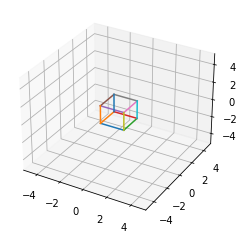

In [9]:
show_3d(corners, edges)

In [10]:
homogeneous_coord = to_homogeneous(corners) # Chaning the corner points to homogeneous coordination
extrinsic_matrix = get_extrinsic_matrix(camera_position, camera_orientation) # Creating the extrinsic matrix with the values that are given from the assignment file

In [11]:
homogeneous_corners = []

# Converting to camera coordinate system via multiplying the extrinsic matrix and the homogeneous coordinates
for h in homogeneous_coord:
    temp = extrinsic_matrix @ h
    homogeneous_corners.append(temp)

homogeneous_corners = np.array(homogeneous_corners)
c_coords = from_homogeneous(homogeneous_corners)    # converting the homogeneous coordinates to noraml coordinates

/tmp/ipykernel_706/1168557974.py:5: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


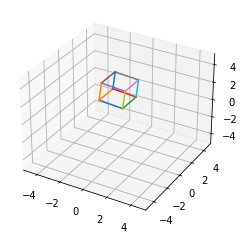

In [12]:
show_3d(c_coords, edges)

In [13]:
homogeneous_coord = to_homogeneous(corners) # Chaning the corner points to homogeneous coordination
extrinsic_matrix = get_extrinsic_matrix(camera_position, camera_orientation) # Creating the extrinsic matrix with the values that are given from the assignment file
instrinsic_matrix = get_instrinsic_matrix(f, s) # creating the instrinsic matrix

In [14]:
homogeneous_corners = []

# Creating the pixel coordinates that are projected
for h in homogeneous_coord:
    temp = instrinsic_matrix @ extrinsic_matrix @ h
    homogeneous_corners.append(temp)

homogeneous_corners = np.array(homogeneous_corners)
p_coords = from_homogeneous(homogeneous_corners)

In [15]:
# from the condition from the assginment file should multiply 200
p_coords = p_coords * 200

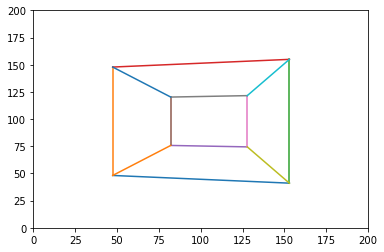

In [16]:
show_2d(p_coords, edges, size=(200, 200))